In [1]:
# Download all the libraries for text data preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
!pip install langdetect

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from langdetect import detect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.utils import to_categorical

In [3]:
# Load datasets
acoustic_features = pd.read_csv('/content/drive/MyDrive/acoustic_features.csv.csv')
lyrics_data = pd.read_csv('/content/drive/MyDrive/lyrics_data.csv')

In [4]:
acoustic_features.head()

,song_id,duration_ms,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo
0,3e9HZxeyfWwjeyPAMmWSSQ,207320,1,1,4,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966
1,5p7ujcrUXASCNwRaWNHR1C,201661,6,1,4,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041
2,2xLMifQCjDGFmkHkpNLD9h,312820,8,1,4,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008
3,3KkXRkHbMCARz0aVfEt68P,158040,2,1,4,0.55600,0.760,0.479,0.000000,0.0703,-5.574,0.0466,0.913,89.911
4,1rqqCSm0Qe4I9rUvWncaom,190947,5,1,4,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014


In [5]:
lyrics_data.head()

,main_genre,song_id,lyrics
0,dance pop,4OafepJy2teCjYJbvFE60J,[ [Intro] Lacigam gnihtemos od ot Thgin laicep...
1,dance pop,5OCJzvD7sykQEKHH7qAC3C,"[ [Chorus] You, you love it how I move you You..."
2,dance pop,2qT1uLXPVPzGgFOx4jtEuo,"[ [Intro] Right now, I'm in a state of mind I ..."
3,dance pop,70khXICDeTTxgYtw3EysKH,['[Chorus] When life deals us cards Make every...
4,dance pop,0WdR2AyLW1Drd3OUdwezM0,"[ [Intro] Back to you, back to you, back to yo..."


In [6]:
# check for duplicate values in both datasets
print(acoustic_features.duplicated().sum())
print(lyrics_data.duplicated().sum())

0
0


In [7]:
# Check for null values in both datasets
print(acoustic_features.isnull().sum())
print(lyrics_data.isnull().sum())

song_id             0
duration_ms         0
key                 0
mode                0
time_signature      0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
valence             0
tempo               0
dtype: int64
main_genre      0
song_id         0
lyrics        104
dtype: int64


**Data Cleaning**

In [8]:
# Determine the percentage of rows with null values in the lyrics feature
null_count = lyrics_data['lyrics'].isnull().sum()
total_rows = len(lyrics_data)
null_percentage = (null_count / total_rows) * 100
print(f"Null lyrics: {null_count}, Total rows: {total_rows}, Percentage: {null_percentage:.2f}%")

Null lyrics: 104, Total rows: 11040, Percentage: 0.94%


In [9]:
# Since the percentage of null values are relatively low, we remove the rows
lyrics_data = lyrics_data.dropna(subset=['lyrics'])

In [10]:
# Check to inspect the null values again
print(lyrics_data.isnull().sum())

main_genre    0
song_id       0
lyrics        0
dtype: int64


In [11]:
# Check the shape of both datasets
print(acoustic_features.shape)
print(lyrics_data.shape)

(20405, 14)
(10936, 3)


In [12]:
# rename the main_genre column to genre
lyrics_data.rename(columns={'main_genre': 'genre'}, inplace=True)

In [13]:
def preprocess_acoustic_features(df):
    acoustic_features['duration_s'] = acoustic_features['duration_ms'] / 1000
    acoustic_features.drop(columns=['duration_ms'], inplace=True)
    return df

acoustic_features = preprocess_acoustic_features(acoustic_features)

In [14]:
acoustic_features.head()

,song_id,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,duration_s
0,3e9HZxeyfWwjeyPAMmWSSQ,1,1,4,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,207.320
1,5p7ujcrUXASCNwRaWNHR1C,6,1,4,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,201.661
2,2xLMifQCjDGFmkHkpNLD9h,8,1,4,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,312.820
3,3KkXRkHbMCARz0aVfEt68P,2,1,4,0.55600,0.760,0.479,0.000000,0.0703,-5.574,0.0466,0.913,89.911,158.040
4,1rqqCSm0Qe4I9rUvWncaom,5,1,4,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,190.947


**Data Preprocessing**
*   Text data preprocessing






In [15]:
# define a function that detects the lang in the lyrics feature
def detect_language(text):
    if not isinstance(text, str):
        return "non-string"
    try:
        return detect(text)
    except:
        return "unknown"

# Apply the function to detect the language of each lyrics
lyrics_data['detected_language'] = lyrics_data['lyrics'].apply(detect_language)

In [16]:
# Filter out English lyrics
lyrics_non_english = lyrics_data[lyrics_data['detected_language'] != 'en']

# display the detected lang
print(lyrics_non_english[['lyrics', 'detected_language']])

                                                  lyrics detected_language
247    ['[Letra de  Única ]  [Intro] Salgo a gastar u...                es
262    [ [Letra de ''Ginza'']  [Intro] Infinity  [Cor...                es
374    ['[Letra de  Felices los 4 ]  [Intro] Maluma b...                es
392    [ [Intro] Na, na, na, na, na Na, na, na, na, n...                tl
432    [ [Letra de Imitadora]  [Intro] Hey Who are yo...                es
...                                                  ...               ...
10908                                          ['♫ ♫ ♫']           unknown
10910  [ Slow down, you move too fast You got to make...                af
10915                                 ['[Instrumental]']                ro
10918                                   ['Instrumental']                ro
10936                                 ['(Instrumental)']                ro

[131 rows x 2 columns]


In [17]:
# Drop the all lyrics not in english and retain only lyrics in english
lyrics_data = lyrics_data[lyrics_data['detected_language'] == 'en']

In [18]:
# drop the detected_language column as it is no longer needed
lyrics_data = lyrics_data.drop(columns=['detected_language'])

In [19]:
#check the shape again
lyrics_data.shape

(10805, 3)

In [20]:
# Import some libraries for text data preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [21]:
# Write a function that cleans the lyrics data
def clean_lyrics(text):
    text = re.sub(r'\[.*?\]', '', text) # Remove section labels
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    stop_words = set(stopwords.words('english')) # Define stop words
    words = text.split() # Split text into words
    filtered_words = [word for word in words if word not in stop_words] # Remove stop words
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words] # Lemmatize words
    cleaned_text = ' '.join(lemmatized_words) # Join words back into a single string
    return cleaned_text

# Apply the function to the lyrics column
lyrics_data['lyrics'] = lyrics_data['lyrics'].apply(clean_lyrics)

In [22]:
lyrics_data.head()

,genre,song_id,lyrics
0,dance pop,4OafepJy2teCjYJbvFE60J,lacigam gnihtemos od ot thgin laiceps ruoy sth...
1,dance pop,5OCJzvD7sykQEKHH7qAC3C,love move love touch one said done youll belie...
2,dance pop,2qT1uLXPVPzGgFOx4jtEuo,right im state mind wanna like time aint got t...
3,dance pop,70khXICDeTTxgYtw3EysKH,life deal u card make everything taste like sa...
4,dance pop,0WdR2AyLW1Drd3OUdwezM0,back back back back back back go back back bac...


**Exploratory Data Analysis**



In [23]:
# Basic statistics of the numerical features
acoustic_features.describe()

,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,duration_s
count,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000,20405.000000
mean,5.224651,0.727028,3.943592,0.265201,0.600342,0.625056,0.047546,0.192335,-8.845186,0.067537,0.607777,120.313409,229.543735
std,3.567111,0.445498,0.289162,0.264370,0.150627,0.197120,0.168418,0.164047,3.593048,0.074369,0.236527,27.683465,67.056961
min,0.000000,0.000000,0.000000,0.000001,0.000000,0.006640,0.000000,0.013000,-30.896000,0.000000,0.000000,0.000000,24.604000
25%,2.000000,0.000000,4.000000,0.039200,0.502000,0.481000,0.000000,0.088300,-11.217000,0.031900,0.427000,99.735000,186.493000
50%,5.000000,1.000000,4.000000,0.169000,0.608000,0.640000,0.000010,0.129000,-8.471000,0.040400,0.632000,118.952000,223.026000
75%,8.000000,1.000000,4.000000,0.440000,0.706000,0.783000,0.001110,0.249000,-6.051000,0.063000,0.804000,135.903000,259.693000
max,11.000000,1.000000,5.000000,0.995000,0.988000,0.998000,0.985000,0.997000,3.440000,0.950000,1.000000,231.028000,1561.133000


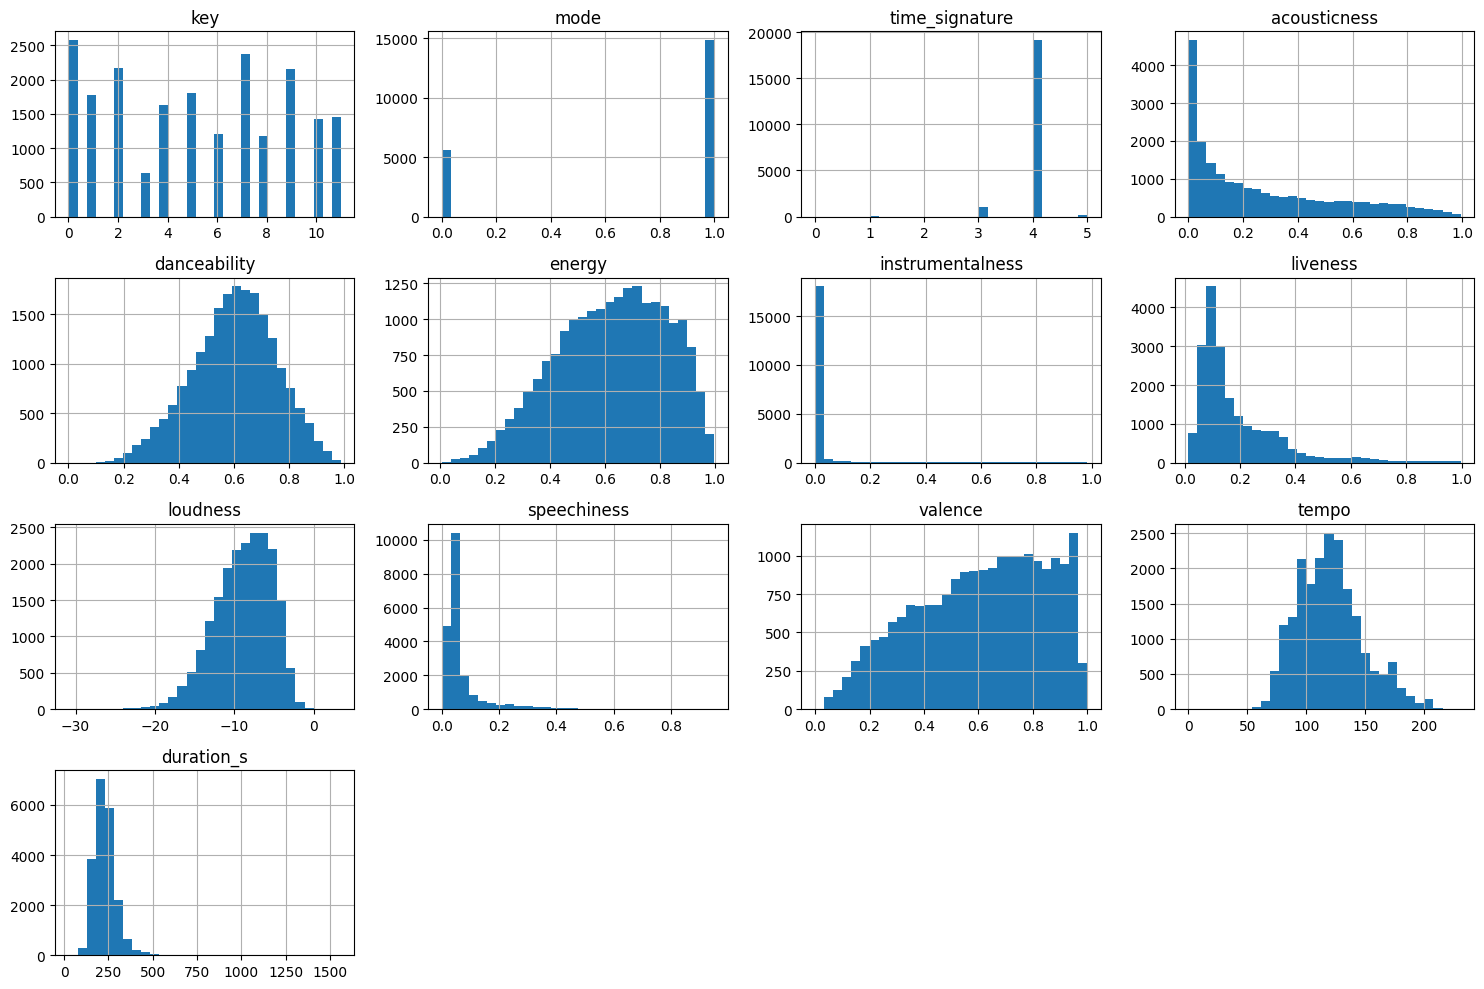

In [24]:
# Plot distributions of numerical features
acoustic_features.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

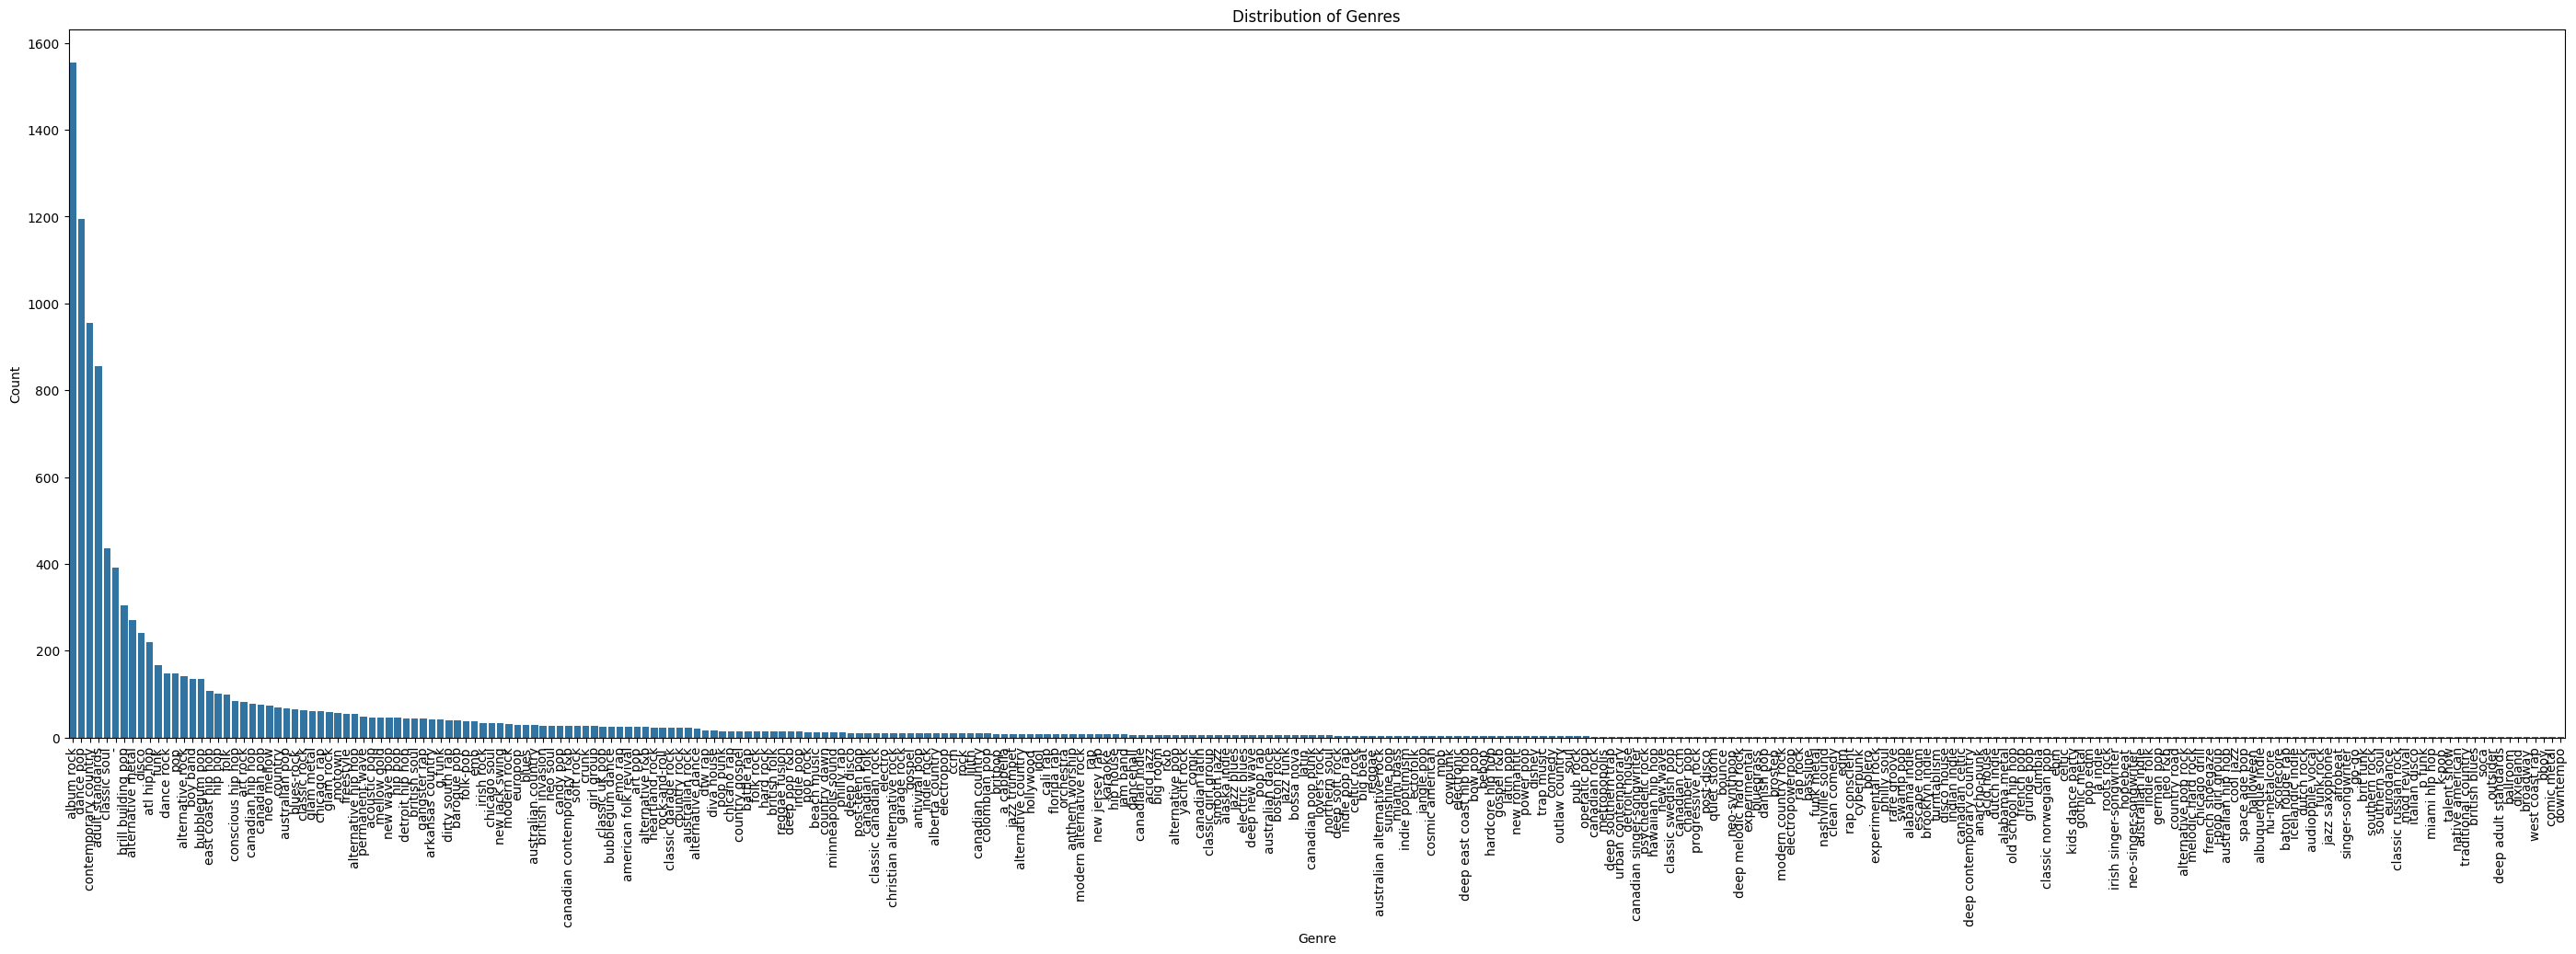

In [25]:
# Display the distribution of genres
genre_distribution = lyrics_data['genre'].value_counts()

# Plot the distribution of genres
plt.figure(figsize=(35, 10))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values)
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [26]:
# Calculate Class Distribution
genre_counts = lyrics_data['genre'].value_counts()
print(genre_counts)

genre
album rock              1554
dance pop               1194
contemporary country     956
adult standards          856
classic soul             436
                        ... 
broadway                   1
west coast rap             1
bboy                       1
comic metal                1
downtempo                  1
Name: count, Length: 292, dtype: int64


In [27]:

# Assuming genre_counts is your Series containing genre counts
total_songs = len(lyrics_data)

genre_percentages = (genre_counts / total_songs) * 100
genre_percentages_df = pd.DataFrame({'Count': genre_counts, 'Percentage (%)': genre_percentages})

print(genre_percentages_df.to_string())

                             Count  Percentage (%)
genre                                             
album rock                    1554       14.382230
dance pop                     1194       11.050440
contemporary country           956        8.847756
adult standards                856        7.922258
classic soul                   436        4.035169
-                              391        3.618695
brill building pop             304        2.813512
alternative metal              271        2.508098
disco                          240        2.221194
atl hip hop                    219        2.026839
funk                           166        1.536326
dance rock                     148        1.369736
pop                            147        1.360481
alternative rock               142        1.314206
boy band                       134        1.240167
bubblegum pop                  134        1.240167
east coast hip hop             107        0.990282
hip hop                        

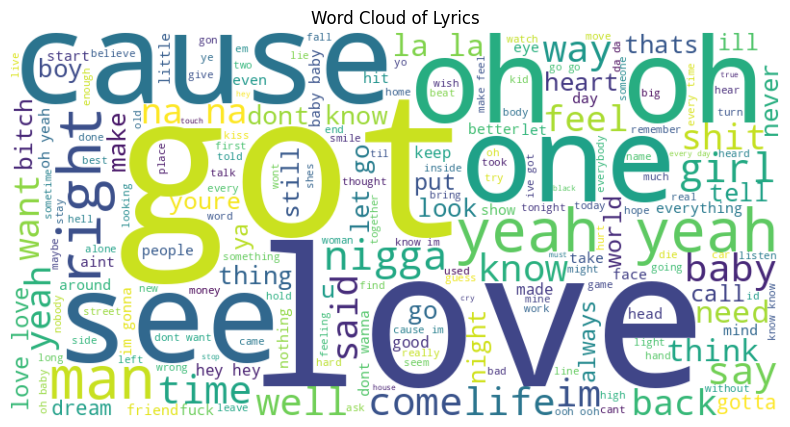

In [28]:
from wordcloud import WordCloud

# Generate a word cloud for the most frequent words in the lyrics
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(lyrics_data['lyrics']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lyrics')
plt.show()

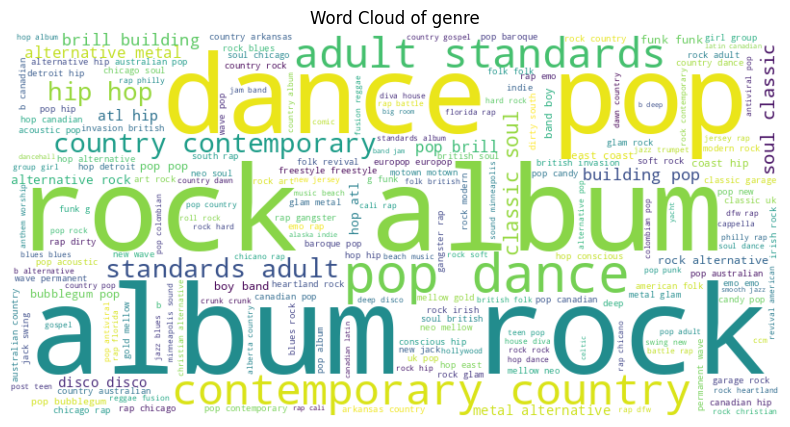

In [29]:
# Generate a word cloud for the most frequent genre
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(lyrics_data['genre']))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of genre')
plt.show()

In [30]:
# Calculate the length of each lyrics sequence
# Extract the lyrics column
lyrics = lyrics_data['lyrics']

# Split the lyrics into individual words
lyrics_lengths = lyrics.apply(lambda x: len(x.split()))

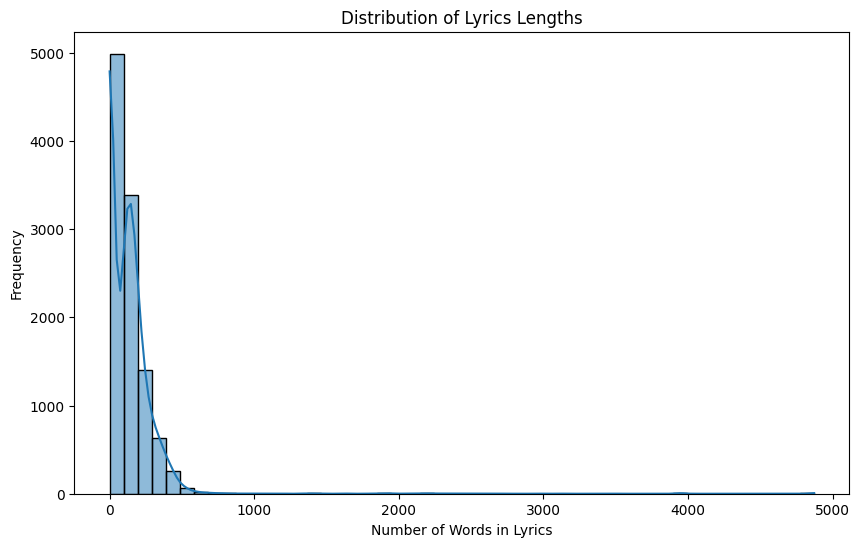

In [31]:
# Plot the distribution of lyrics lengths
plt.figure(figsize=(10, 6))
sns.histplot(lyrics_lengths, bins=50, kde=True)
plt.xlabel('Number of Words in Lyrics')
plt.ylabel('Frequency')
plt.title('Distribution of Lyrics Lengths')
plt.show()

In [32]:
# Choose the max sequence length (e.g., 95th percentile)
max_sequence_length = int(np.percentile(lyrics_lengths, 95))
print(f'Max sequence length (95th percentile): {max_sequence_length}')

Max sequence length (95th percentile): 359


**Feature Engineering**

In [33]:
# Merge the datasets on 'song_id'
data = pd.merge(acoustic_features, lyrics_data, on='song_id')

In [34]:
# Drop the song_id,
data.drop(columns=['song_id'], inplace=True)

In [35]:
data.columns

Index(['key', 'mode', 'time_signature', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'valence', 'tempo', 'duration_s', 'genre', 'lyrics'],
      dtype='object')

In [36]:
# Inspect the merged data
data.head()

,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,duration_s,genre,lyrics
0,8,1,4,0.00513,0.834,0.730,0.00000,0.1240,-3.714,0.2220,0.446,155.008,312.820,pop,astro yeah sun freezin cold already know winte...
1,5,1,4,0.19300,0.579,0.904,0.00000,0.0640,-2.729,0.0618,0.681,82.014,190.947,baroque pop,high high hope high high hope living shooting ...
2,7,1,4,0.16400,0.335,0.625,0.00000,0.0708,-7.462,0.0386,0.346,150.277,241.107,dance pop,iii dont want lot christmas one thing need don...
3,7,1,3,0.76600,0.240,0.598,0.00000,0.1170,-8.435,0.0370,0.776,202.082,151.933,adult standards,wonderful time year kid jingle belling everyon...
4,4,1,4,0.19400,0.729,0.625,0.00986,0.2480,-5.266,0.0315,0.261,146.034,183.907,rap,yrold bitch daytrip took got hoe callin young ...


In [37]:
# Check for the shape of the data again
data.shape

(10805, 15)

In [38]:
# Check for null values again
data.isnull().sum()

key                 0
mode                0
time_signature      0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
valence             0
tempo               0
duration_s          0
genre               0
lyrics              0
dtype: int64

In [39]:
# We now scale the numerical features using minmaxscaler
scaler = MinMaxScaler()
numerical_features = ['key', 'mode', 'time_signature', 'acousticness', 'danceability', 'energy', 
                      'instrumentalness', 'liveness', 'loudness', 'speechiness','valence', 'tempo', 'duration_s']
acoustic_scaled = scaler.fit_transform(data[numerical_features])

In [40]:
# One hot encoding for the target variable
encoder = OneHotEncoder(sparse=False)
genres_encoded = encoder.fit_transform(data['genre'].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [41]:
tokenizer = Tokenizer(num_words=10000)  # Limit to top 10,000 words
tokenizer.fit_on_texts(lyrics_data['lyrics'])
sequences = tokenizer.texts_to_sequences(lyrics_data['lyrics'])
max_sequence_length = 500  # Define max sequence length based on your EDA
lyrics_padded = pad_sequences(sequences, maxlen=max_sequence_length)

In [42]:
# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/glove.6B.100d.txt'
embedding_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [43]:
# Create an embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
# Combine all features and handle imbalance using SMOTE
combined_features = np.hstack((acoustic_scaled, lyrics_padded))

In [45]:
# Check class distribution
genre_counts = pd.DataFrame(genres_encoded, columns=encoder.get_feature_names_out()).sum()
print(genre_counts)

x0_-                     391.0
x0_a cappella              8.0
x0_acid house              1.0
x0_acid jazz               6.0
x0_acoustic pop           47.0
                         ...  
x0_trap music              3.0
x0_turntablism             1.0
x0_urban contemporary      2.0
x0_west coast rap          1.0
x0_yacht rock              6.0
Length: 292, dtype: float64


In [46]:
from imblearn.over_sampling import SMOTE
# Manually duplicate samples for small classes
min_samples_required = 6  # Set a minimum required samples, for example, 6

for idx, count in enumerate(genre_counts):
    if count < min_samples_required:
        diff = int(min_samples_required - count)
        class_samples = combined_features[genres_encoded[:, idx] == 1]
        class_labels = genres_encoded[genres_encoded[:, idx] == 1]
        combined_features = np.vstack((combined_features, np.tile(class_samples, (diff, 1))))
        genres_encoded = np.vstack((genres_encoded, np.tile(class_labels, (diff, 1))))

# Apply SMOTE with adjusted parameters
smote = SMOTE(random_state=42, k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(combined_features, genres_encoded)


In [47]:
# Split the data for model building
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [48]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Acoustic features branch
acoustic_input = Input(shape=(acoustic_scaled.shape[1],), name='acoustic_input')
x1 = Dense(128, activation='relu')(acoustic_input)
x1 = Dropout(0.5)(x1)

In [49]:
# Lyrics branch
lyrics_input = Input(shape=(max_sequence_length,), name='lyrics_input')
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=False)(lyrics_input)
x2 = LSTM(128, return_sequences=False)(embedding_layer)
x2 = Dropout(0.5)(x2)

In [50]:
# Concatenate both branches
concatenated = Concatenate()([x1, x2])
output = Dense(genres_encoded.shape[1], activation='softmax')(concatenated)

In [51]:
# Define the model
model = Model(inputs=[acoustic_input, lyrics_input], outputs=output)

In [52]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lyrics_input (InputLayer)   [(None, 500)]                0         []                            
                                                                                                  
 acoustic_input (InputLayer  [(None, 13)]                 0         []                            
 )                                                                                                
                                                                                                  
 embedding (Embedding)       (None, 500, 100)             3577600   ['lyrics_input[0][0]']        
                                                                                                  
 dense (Dense)               (None, 128)                  1792      ['acoustic_input[0][0]']  

In [54]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [55]:
# Train the model
history = model.fit(
    {'acoustic_input': X_train[:, :acoustic_scaled.shape[1]], 'lyrics_input': X_train[:, acoustic_scaled.shape[1]:]},
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
9076/9076 [==============================] - 200s 21ms/step - loss: 2.4285 - accuracy: 0.4881 - val_loss: 1.6318 - val_accuracy: 0.6379
Epoch 2/20
9076/9076 [==============================] - 191s 21ms/step - loss: 1.6396 - accuracy: 0.6260 - val_loss: 1.2660 - val_accuracy: 0.7110
Epoch 3/20
9076/9076 [==============================] - 193s 21ms/step - loss: 1.3922 - accuracy: 0.6753 - val_loss: 1.0905 - val_accuracy: 0.7466
Epoch 4/20
9076/9076 [==============================] - 194s 21ms/step - loss: 1.2500 - accuracy: 0.7036 - val_loss: 0.9795 - val_accuracy: 0.7692
Epoch 5/20
9076/9076 [==============================] - 208s 23ms/step - loss: 1.1482 - accuracy: 0.7247 - val_loss: 0.8844 - val_accuracy: 0.7909
Epoch 6/20
9076/9076 [==============================] - 254s 28ms/step - loss: 1.1386 - accuracy: 0.7257 - val_loss: 0.9147 - val_accuracy: 0.7804
Epoch 7/20
9076/9076 [==============================] - 220s 24ms/step - loss: 1.1017 - accuracy: 0.7326 - val_loss: 0

In [56]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(
    {'acoustic_input': X_test[:, :acoustic_scaled.shape[1]], 'lyrics_input': X_test[:, acoustic_scaled.shape[1]:]},
    y_test
)

2837/2837 [==============================] - 30s 11ms/step - loss: 0.6424 - accuracy: 0.8375


In [57]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.6424425840377808
Test Accuracy: 0.8375278115272522


In [58]:
# Predict on the test set
y_pred = model.predict(
    {'acoustic_input': X_test[:, :acoustic_scaled.shape[1]], 'lyrics_input': X_test[:, acoustic_scaled.shape[1]:]}
)

2837/2837 [==============================] - 26s 9ms/step


In [59]:
# Convert predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [63]:
from sklearn.metrics import classification_report

# Classification Report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=encoder.categories_[0])
print('Classification Report:')
print(class_report)

Classification Report:
                             precision    recall  f1-score   support

                          -       0.23      0.01      0.02       320
                 a cappella       0.87      0.95      0.91       307
                 acid house       1.00      1.00      1.00       297
                  acid jazz       0.91      0.98      0.95       303
               acoustic pop       0.45      0.42      0.43       318
            adult standards       0.23      0.05      0.09       285
                   afrobeat       1.00      1.00      1.00       319
              alabama indie       1.00      1.00      1.00       308
              alabama metal       1.00      1.00      1.00       305
               alaska indie       0.87      0.97      0.92       293
            alberta country       0.84      0.98      0.91       313
                 album rock       0.23      0.06      0.10       261
          albuquerque indie       1.00      1.00      1.00       302
        al

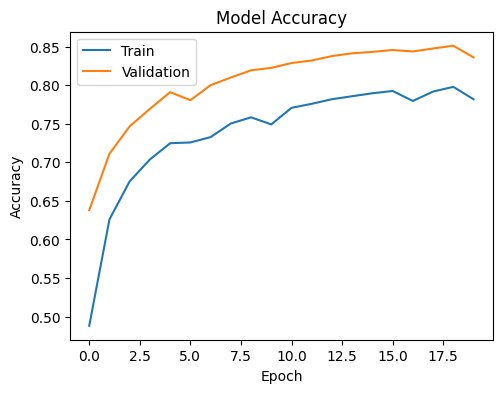

In [64]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

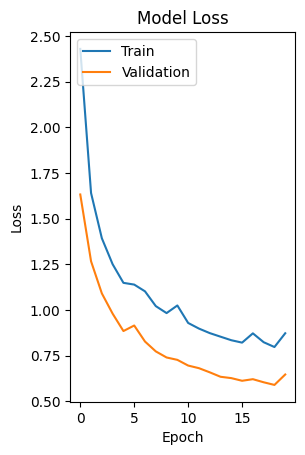

In [65]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()